In [64]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

# -------- load feature data --------
FEATURES_CSV = r"C:\Users\lilin\OneDrive\Desktop\Project\EMG\Features\P3P4_EMG_butter_low_high.csv"


df = pd.read_csv(FEATURES_CSV)

# -------- X, y, groups --------
# EMG feature columns
emg_cols = [c for c in df.columns if c.startswith("EMG_MVC_CH")]

# optional condition features
cond_cols = [c for c in ["Lifting Height", "Load Type", "Lifting Depth"]
             if c in df.columns]

X_base = df[emg_cols + cond_cols]
X = pd.get_dummies(X_base, drop_first=True)

# turn box weight into 5 classes (as strings)
y = df["Box Weight"].round(1).astype(str)   # e.g., "2.3", "4.5", ...

# group by trial so all windows from a trial stay together
groups = df["Timeline"]

# -------- grouped train/test split --------
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# -------- random forest classifier --------
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=3,
    max_features="sqrt",
    bootstrap=True,
    random_state=42,
)
clf.fit(X_train, y_train)

# -------- evaluation --------
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)

print(f"Train accuracy: {train_acc:.3f}")
print(f"Test  accuracy: {test_acc:.3f}")
# print("\nTest classification report:")
# print(classification_report(y_test, y_test_pred))
print("Train:", y_train.value_counts())
print("Test :", y_test.value_counts())



Train accuracy: 0.410
Test  accuracy: 0.266
Train: Box Weight
6.8     9665
2.3     5801
11.3    5310
9.1     5304
4.5     4269
Name: count, dtype: int64
Test : Box Weight
6.8     3383
4.5     1902
9.1     1863
11.3    1419
Name: count, dtype: int64


Confusion matrix (counts):
[[ 160  571  311  288   89]
 [ 202  111   14  947  567]
 [ 214  556  315  562  255]
 [ 695  978  626  426  339]
 [ 465   87   18 1136   14]]


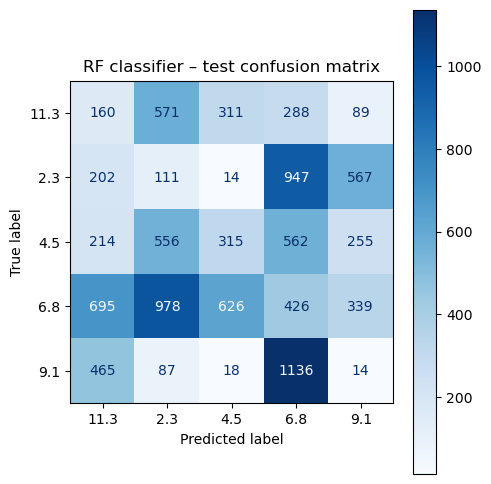

Train accuracy: 0.434
Test  accuracy: 0.103
Train class counts:
 Box Weight
6.8     9984
9.1     5447
11.3    5310
4.5     4269
2.3     3960
Name: count, dtype: int64
Test class counts:
 Box Weight
6.8     3064
4.5     1902
2.3     1841
9.1     1720
11.3    1419
Name: count, dtype: int64

Test classification report:
              precision    recall  f1-score   support

        11.3       0.07      0.08      0.07      1419
         2.3       0.07      0.07      0.07      1841
         4.5       0.23      0.20      0.21      1902
         6.8       0.14      0.17      0.15      3064
         9.1       0.01      0.00      0.00      1720

    accuracy                           0.11      9946
   macro avg       0.10      0.10      0.10      9946
weighted avg       0.11      0.11      0.11      9946



In [89]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

# -------- load feature data --------
FEATURES_CSV = r"C:\Users\lilin\OneDrive\Desktop\Project\EMG\Features\P3P4_EMG_butter_low_high.csv"

df = pd.read_csv(FEATURES_CSV)

# -------- X, y, groups --------
# EMG feature columns
emg_cols = [c for c in df.columns if c.startswith("EMG_MVC_CH")]

# optional condition features
cond_cols = [c for c in ["Lifting Height", "Load Type", "Lifting Depth"]
             if c in df.columns]

X_base = df[emg_cols + cond_cols]
X = pd.get_dummies(X_base, drop_first=True)

# turn box weight into 5 classes (as strings)
y = df["Box Weight"].round(1).astype(str)   # e.g., "2.3", "4.5", ...
groups = df["Timeline"]

# -------- grouped + per-class train/test split --------
weights = sorted(df["Box Weight"].round(1).unique())  # numeric weights

train_idx_all = []
test_idx_all  = []

for w in weights:
    mask = df["Box Weight"].round(1) == w
    X_w      = X[mask]
    y_w      = y[mask]
    groups_w = groups[mask]

    # need at least 2 groups to split
    if groups_w.nunique() < 2:
        continue

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx_w, te_idx_w = next(gss.split(X_w, y_w, groups_w))

    global_idx = np.where(mask.values)[0]
    train_idx_all.extend(global_idx[tr_idx_w])
    test_idx_all.extend(global_idx[te_idx_w])

train_idx_all = np.array(train_idx_all)
test_idx_all  = np.array(test_idx_all)

X_train, X_test = X.iloc[train_idx_all], X.iloc[test_idx_all]
y_train, y_test = y.iloc[train_idx_all], y.iloc[test_idx_all]

# -------- random forest classifier --------
clf = RandomForestClassifier(

    n_estimators=100,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=3,
    max_features="sqrt",
    bootstrap=True,
    class_weight="balanced",
    random_state=42,
)
clf.fit(X_train, y_train)

# -------- evaluation --------
y_tr_pred = clf.predict(X_train)
y_te_pred = clf.predict(X_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# confusion matrix on test set
cm = confusion_matrix(y_test, y_te_pred, labels=sorted(y.unique()))
print("Confusion matrix (counts):")
print(cm)

# optional: plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sorted(y.unique()))
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("RF classifier – test confusion matrix")
plt.tight_layout()
plt.show()

train_acc = accuracy_score(y_train, y_tr_pred)
test_acc  = accuracy_score(y_test, y_te_pred)

print(f"Train accuracy: {train_acc:.3f}")
print(f"Test  accuracy: {test_acc:.3f}")
print("Train class counts:\n", y_train.value_counts())
print("Test class counts:\n", y_test.value_counts())
print("\nTest classification report:")
print(classification_report(y_test, y_test_pred))


In [65]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

# full feature table
df = pd.read_csv(r"C:\Users\lilin\OneDrive\Desktop\Project\EMG\Features\P3P4_EMG_butter_low_high.csv")  

load_types = ["Horizontal box", "Sand bag", "Vertical box"]

for load in load_types:
    print(f"\n=== Load type: {load} ===")
    df_sub = df[df["Load Type"] == load].copy()
    if len(df_sub) < 50:
        print("  Not enough samples, skipping.")
        continue

    # features: all EMG_MVC_* features + optional height/depth
    emg_cols  = [c for c in df_sub.columns if c.startswith("EMG_MVC_CH")]
    cond_cols = [c for c in ["Lifting Height", "Lifting Depth"] if c in df_sub.columns]

    X_base = df_sub[emg_cols + cond_cols]
    X = pd.get_dummies(X_base, drop_first=True)

    # classify box weight into 5 classes
    y = df_sub["Box Weight"].round(1).astype(str)

    groups = df_sub["Timeline"]

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups))

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=4,
        min_samples_split=10,
        min_samples_leaf=3,
        max_features="sqrt",
        bootstrap=True,
        random_state=42,
    )
    clf.fit(X_train, y_train)

    y_tr_pred = clf.predict(X_train)
    y_te_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_tr_pred)
    test_acc  = accuracy_score(y_test, y_te_pred)

    print(f"  N = {len(df_sub)}")
    print(f"  Train accuracy: {train_acc:.3f}")
    print(f"  Test  accuracy: {test_acc:.3f}")
    # print("  Test classification report:")
    # print(classification_report(y_test, y_te_pred, digits=3))
    print("Train:", y_train.value_counts())
    print("Test :", y_test.value_counts())




=== Load type: Horizontal box ===
  N = 14086
  Train accuracy: 0.410
  Test  accuracy: 0.274
Train: Box Weight
6.8     3484
2.3     2130
11.3    1980
9.1     1940
4.5     1503
Name: count, dtype: int64
Test : Box Weight
6.8     1246
9.1      655
4.5      654
11.3     494
Name: count, dtype: int64

=== Load type: Sand bag ===
  N = 10758
  Train accuracy: 0.491
  Test  accuracy: 0.235
Train: Box Weight
6.8     2683
2.3     1614
9.1     1463
11.3    1425
4.5     1242
Name: count, dtype: int64
Test : Box Weight
6.8     929
4.5     513
9.1     476
11.3    413
Name: count, dtype: int64

=== Load type: Vertical box ===
  N = 14072
  Train accuracy: 0.446
  Test  accuracy: 0.267
Train: Box Weight
6.8     3498
2.3     2057
11.3    1905
9.1     1901
4.5     1524
Name: count, dtype: int64
Test : Box Weight
6.8     1208
4.5      735
9.1      732
11.3     512
Name: count, dtype: int64



=== Load type: Horizontal box ===
Confusion matrix (counts):
[[101  23  77 284   9]
 [ 68   2   0 514 108]
 [ 75   1   9 488  81]
 [318  45  51 708  46]
 [135   0   1 457   0]]


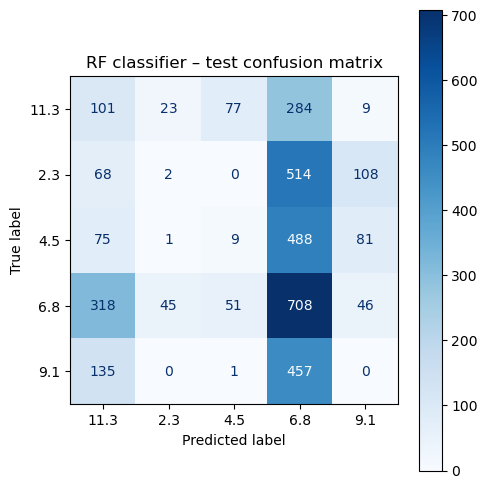

  N = 14086
  Train accuracy: 0.461
  Test  accuracy: 0.228
  Train class counts:
 Box Weight
6.8     3562
9.1     2002
11.3    1980
4.5     1503
2.3     1438
Name: count, dtype: int64
  Test class counts:
 Box Weight
6.8     1168
2.3      692
4.5      654
9.1      593
11.3     494
Name: count, dtype: int64

=== Load type: Sand bag ===
Confusion matrix (counts):
[[ 27  78  15 293   0]
 [ 40   7   2 374  51]
 [126  64   9 307   7]
 [ 90  96   6 597  19]
 [120   0   1 372   0]]


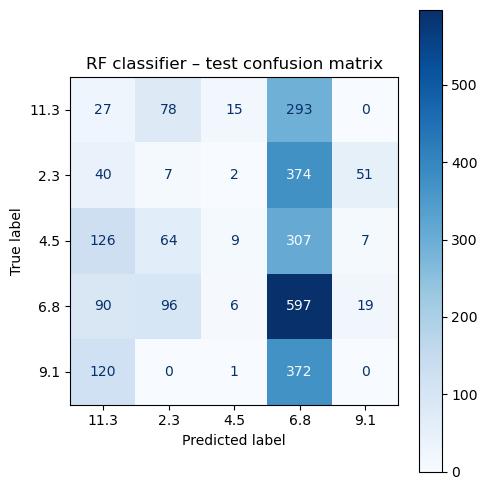

  N = 10758
  Train accuracy: 0.513
  Test  accuracy: 0.237
  Train class counts:
 Box Weight
6.8     2804
9.1     1446
11.3    1425
4.5     1242
2.3     1140
Name: count, dtype: int64
  Test class counts:
 Box Weight
6.8     808
4.5     513
9.1     493
2.3     474
11.3    413
Name: count, dtype: int64

=== Load type: Vertical box ===
Confusion matrix (counts):
[[ 20  73   3 356  60]
 [ 61   7   3 590  14]
 [ 28  93   9 536  69]
 [184  94   7 757  46]
 [ 39  40   0 553   2]]


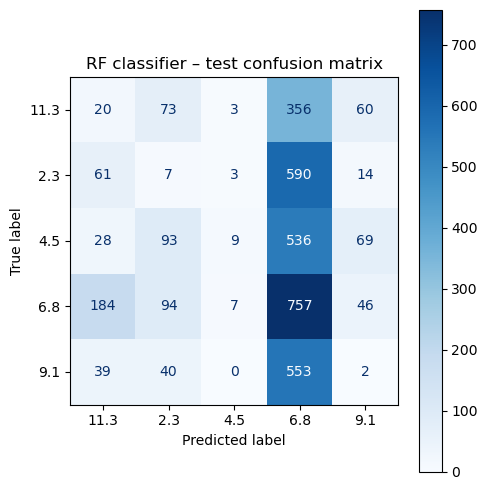

  N = 14072
  Train accuracy: 0.472
  Test  accuracy: 0.218
  Train class counts:
 Box Weight
6.8     3618
9.1     1999
11.3    1905
4.5     1524
2.3     1382
Name: count, dtype: int64
  Test class counts:
 Box Weight
6.8     1088
4.5      735
2.3      675
9.1      634
11.3     512
Name: count, dtype: int64


In [86]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

# full feature table
df = pd.read_csv(r"C:\Users\lilin\OneDrive\Desktop\Project\EMG\Features\P3P4_EMG_butter_low_high.csv")  

load_types = ["Horizontal box", "Sand bag", "Vertical box"]

for load in load_types:
    print(f"\n=== Load type: {load} ===")
    df_sub = df[df["Load Type"] == load].copy()
    if len(df_sub) < 50:
        print("  Not enough samples, skipping.")
        continue

    # features: all EMG_MVC_* features + optional height/depth
    emg_cols  = [c for c in df_sub.columns if c.startswith("EMG_MVC_CH")]
    cond_cols = [c for c in ["Lifting Height", "Lifting Depth"] if c in df_sub.columns]

    X_base = df_sub[emg_cols + cond_cols]
    X = pd.get_dummies(X_base, drop_first=True)

    # classify box weight into classes
    y = df_sub["Box Weight"].round(1).astype(str)
    groups = df_sub["Timeline"]

    # -------- grouped + per-class train/test split --------
    weights = sorted(df_sub["Box Weight"].round(1).unique())
    train_idx_all = []
    test_idx_all  = []

    for w in weights:
        mask = df_sub["Box Weight"].round(1) == w
        X_w      = X[mask]
        y_w      = y[mask]
        groups_w = groups[mask]

        # need at least 2 trials to split for this weight
        if groups_w.nunique() < 2:
            continue

        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        tr_idx_w, te_idx_w = next(gss.split(X_w, y_w, groups_w))

        # indices relative to df_sub / X
        global_idx = np.where(mask.values)[0]
        train_idx_all.extend(global_idx[tr_idx_w])
        test_idx_all.extend(global_idx[te_idx_w])

    train_idx_all = np.array(train_idx_all)
    test_idx_all  = np.array(test_idx_all)

    X_train, X_test = X.iloc[train_idx_all], X.iloc[test_idx_all]
    y_train, y_test = y.iloc[train_idx_all], y.iloc[test_idx_all]

    clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=1,
        max_features="sqrt",
        bootstrap=True,
        random_state=42,
    )
    clf.fit(X_train, y_train)

    y_tr_pred = clf.predict(X_train)
    y_te_pred = clf.predict(X_test)

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    # confusion matrix on test set
    cm = confusion_matrix(y_test, y_te_pred, labels=sorted(y.unique()))
    print("Confusion matrix (counts):")
    print(cm)

    # optional: plot it
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=sorted(y.unique()))
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title("RF classifier – test confusion matrix")
    plt.tight_layout()
    plt.show()

    train_acc = accuracy_score(y_train, y_tr_pred)
    test_acc  = accuracy_score(y_test, y_te_pred)

    print(f"  N = {len(df_sub)}")
    print(f"  Train accuracy: {train_acc:.3f}")
    print(f"  Test  accuracy: {test_acc:.3f}")
    print("  Train class counts:\n", y_train.value_counts())
    print("  Test class counts:\n", y_test.value_counts())
    # print("  Test classification report:")
    # print(classification_report(y_test, y_te_pred, digits=3))


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

# ----- settings -----
INPUT_PATH = r"C:\Users\lilin\OneDrive\Desktop\Project\EMG\Features\P4_EMG_butter_low_high.csv" 

# ----- load & filter -----
df = pd.read_csv(INPUT_PATH)

# keep only the three target weights
target_weights = [2.3, 6.8, 11.3]
df = df[df["Box Weight"].round(1).isin(target_weights)].copy()

print("N samples after filtering:", len(df))

# ----- features -----
emg_cols  = [c for c in df.columns if c.startswith("EMG_MVC_CH")]
cond_cols = [c for c in ["Lifting Height", "Load Type", "Lifting Depth"] if c in df.columns]

X_base = df[emg_cols + cond_cols]
X = pd.get_dummies(X_base, drop_first=True)

# 3-class target
y = df["Box Weight"].round(1).astype(str)  # labels: "2.3", "6.8", "11.3"

# group by trial so windows from the same trial don't leak
groups = df["Timeline"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# ----- RF classifier -----
clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=3,
        min_samples_split=10,
        min_samples_leaf=3,
        max_features="sqrt",
        bootstrap=True,
        random_state=42,
)

clf.fit(X_train, y_train)

y_tr_pred = clf.predict(X_train)
y_te_pred = clf.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, y_tr_pred))
print("Test  accuracy:", accuracy_score(y_test, y_te_pred))
# print("\nTest classification report:")
# print(classification_report(y_test, y_te_pred, digits=3))
print("Train:", y_train.value_counts())
print("Test :", y_test.value_counts())


N samples after filtering: 12526
Train accuracy: 0.7791600212652844
Test  accuracy: 0.0
Train: Box Weight
6.8     6444
11.3    2961
Name: count, dtype: int64
Test : Box Weight
2.3    3121
Name: count, dtype: int64


N samples after filtering: 12526
Confusion matrix (counts):
[[  34  694  691]
 [ 195  202 1444]
 [ 353  822  427]]


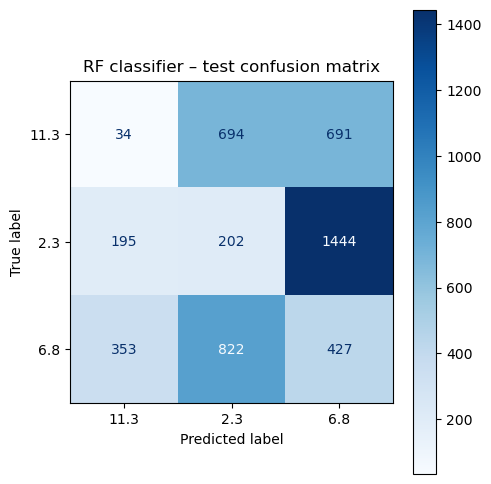

Train accuracy: 0.7643528183716075
Test  accuracy: 0.13636363636363635
Train class counts:
 Box Weight
6.8     4842
11.3    1542
2.3     1280
Name: count, dtype: int64
Test class counts:
 Box Weight
2.3     1841
6.8     1602
11.3    1419
Name: count, dtype: int64

Test classification report:
              precision    recall  f1-score   support

        11.3      0.058     0.024     0.034      1419
         2.3      0.118     0.110     0.114      1841
         6.8      0.167     0.267     0.205      1602

    accuracy                          0.136      4862
   macro avg      0.114     0.133     0.118      4862
weighted avg      0.116     0.136     0.120      4862



In [94]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

# ----- settings -----
INPUT_PATH = r"C:\Users\lilin\OneDrive\Desktop\Project\EMG\Features\P4_EMG_butter_low_high.csv" 

# ----- load & filter -----
df = pd.read_csv(INPUT_PATH)

# keep only the three target weights
target_weights = [2.3, 6.8, 11.3]
df = df[df["Box Weight"].round(1).isin(target_weights)].copy()

print("N samples after filtering:", len(df))

# ----- features -----
emg_cols  = [c for c in df.columns if c.startswith("EMG_MVC_CH")]
cond_cols = [c for c in ["Lifting Height", "Load Type", "Lifting Depth"] if c in df.columns]

X_base = df[emg_cols + cond_cols]
X = pd.get_dummies(X_base, drop_first=True)

# 3-class target
y = df["Box Weight"].round(1).astype(str)  # labels: "2.3", "6.8", "11.3"
groups = df["Timeline"]

# ----- grouped + per-weight train/test split -----
weights = sorted(df["Box Weight"].round(1).unique())

train_idx_all = []
test_idx_all  = []

for w in weights:
    mask = df["Box Weight"].round(1) == w
    X_w      = X[mask]
    y_w      = y[mask]
    groups_w = groups[mask]

    # need at least 2 timelines for this weight to split
    if groups_w.nunique() < 2:
        print(f"  Skipping weight {w}: not enough distinct timelines to split.")
        continue

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx_w, te_idx_w = next(gss.split(X_w, y_w, groups_w))

    global_idx = np.where(mask.values)[0]
    train_idx_all.extend(global_idx[tr_idx_w])
    test_idx_all.extend(global_idx[te_idx_w])

train_idx_all = np.array(train_idx_all)
test_idx_all  = np.array(test_idx_all)

X_train, X_test = X.iloc[train_idx_all], X.iloc[test_idx_all]
y_train, y_test = y.iloc[train_idx_all], y.iloc[test_idx_all]

# ----- RF classifier -----
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=3,
    max_features="sqrt",
    bootstrap=True,
    class_weight="balanced",
    random_state=42,
)

clf.fit(X_train, y_train)

y_tr_pred = clf.predict(X_train)
y_te_pred = clf.predict(X_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# confusion matrix on test set
cm = confusion_matrix(y_test, y_te_pred, labels=sorted(y.unique()))
print("Confusion matrix (counts):")
print(cm)

# optional: plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sorted(y.unique()))
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("RF classifier – test confusion matrix")
plt.tight_layout()
plt.show()

print("Train accuracy:", accuracy_score(y_train, y_tr_pred))
print("Test  accuracy:", accuracy_score(y_test, y_te_pred))
print("Train class counts:\n", y_train.value_counts())
print("Test class counts:\n", y_test.value_counts())
print("\nTest classification report:")
print(classification_report(y_test, y_te_pred, digits=3))
